In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import functools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn import metrics

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence


import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca, model
from lob_data_utils.svm_calculation import lob_svm


from keras import backend as K

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')
import tensorflow as tf
def as_keras_metric(method):
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value

    return wrapper


auc_roc = as_keras_metric(tf.metrics.auc)

Using TensorFlow backend.


In [2]:
data_length = 10000
stock = '9062'
gdf_filename_pattern = 'gdf_{}_' + 'len{}'.format(data_length) + '_r{}_s{}_K50'
gdf_parameters = [(1.0, 1.0), (0.1, 0.1), (0.1, 1.0), (1.0, 0.1), (0.01, 0.1)]

In [3]:
df_log = pd.read_csv('../gdf_pca/res_log_que.csv')   
df_log = df_log[df_log['stock'] == int(stock)]
columns = [c for c in df_log.columns if 'matthews' in c or 'roc_auc' in c]
df_log[columns]

,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,train_val_matthews,train_val_roc_auc
17,0.068364,0.534164,0.10818,0.554053,0.071634,0.535742,0.065592,0.532787


In [4]:
gdf_dfs = []
for r, s in gdf_parameters:
    gdf_dfs.append(gdf_pca.SvmGdfResults(
        stock,  r=r, s=s, data_length=data_length, 
        gdf_filename_pattern=gdf_filename_pattern))

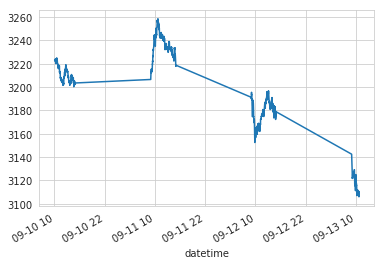

In [5]:
gdf_dfs[1].df['mid_price'].iloc[0:1000].plot()

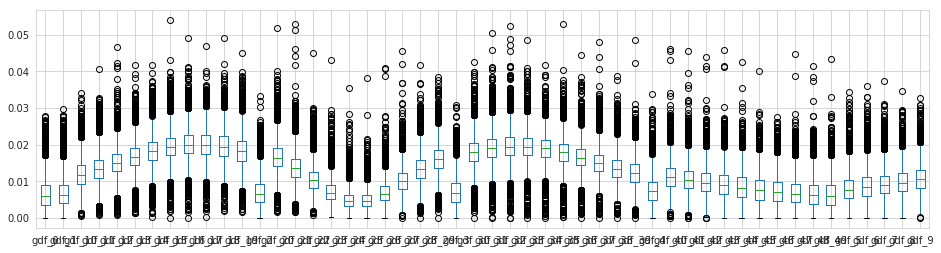

In [6]:
plt.figure(figsize=(16, 4))
gdf_dfs[4].df[[c for c in gdf_dfs[1].df.columns if 'gdf' in c]].boxplot()

In [9]:
max_features = 1024
model2 = Sequential()
model2.add(LSTM(20))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc])
gdf_dfs[0].train_lstm(model2, feature_name='pca_n_gdf_que',
                      compile_kwargs={'loss': 'binary_crossentropy', 'optimizer': 'adam', 'metrics': [auc_roc]},
                      fit_kwargs={'epochs': 5, 'batch_size': 10, 'verbose': 1}, plot_name='here.png')

Epoch 1/5
3635/3635 [==============================] - 7s 2ms/step - loss: 0.6917 - auc: 0.5161
Epoch 2/5
3635/3635 [==============================] - 4s 1ms/step - loss: 0.6890 - auc: 0.5444
Epoch 3/5
3635/3635 [==============================] - 3s 853us/step - loss: 0.6884 - auc: 0.5462
Epoch 4/5
3635/3635 [==============================] - 2s 641us/step - loss: 0.6884 - auc: 0.5505
Epoch 5/5
3635/3635 [==============================] - 2s 644us/step - loss: 0.6882 - auc: 0.5515
Epoch 1/5
3635/3635 [==============================] - 5s 1ms/step - loss: 0.6890 - auc: 0.5700
Epoch 2/5
3635/3635 [==============================] - 2s 633us/step - loss: 0.6889 - auc: 0.5502
Epoch 3/5
3635/3635 [==============================] - 3s 835us/step - loss: 0.6887 - auc: 0.5538
Epoch 4/5
3635/3635 [==============================] - 4s 991us/step - loss: 0.6888 - auc: 0.5525
Epoch 5/5
3635/3635 [==============================] - 4s 1ms/step - loss: 0.6888 - auc: 0.5530
Epoch 1/5
3635/3635 [=======

{'precision': 0.5439391386516961,
 'f1': 0.5402219240496184,
 'recall': 0.5368428358434996,
 'roc_auc': 0.5390000212653696,
 'kappa': 0.07799505187046354,
 'matthews': 0.07804547531861512,
 'train_val_precision': 0.532782749357779,
 'train_val_f1': 0.5338660031684703,
 'train_val_recall': 0.5351318318172479,
 'train_val_roc_auc': 0.5334291887548817,
 'train_val_kappa': 0.0668570440117616,
 'train_val_matthews': 0.06687987833733963,
 'train_precision': 0.5405993233446109,
 'train_f1': 0.5476802546211287,
 'train_recall': 0.5549491441329695,
 'train_roc_auc': 0.5379332414213235,
 'train_kappa': 0.07588247294875206,
 'train_matthews': 0.07590965848476003,
 'stock': '9062',
 'kernel': 'lstm',
 'features': 'pca_n_gdf_que_prev',
 'pca_components': 3,
 'test_precision': 0.5614035087719298,
 'test_f1': 0.5779467680608364,
 'test_recall': 0.5954946131243879,
 'test_roc_auc': 0.5549047707748729,
 'test_kappa': 0.10995632793658272,
 'test_matthews': 0.11016925476529703}

In [8]:
df_log[columns]

,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,train_val_matthews,train_val_roc_auc
17,0.068364,0.534164,0.10818,0.554053,0.071634,0.535742,0.065592,0.532787


In [12]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 20)                1920      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 1,941
Trainable params: 1,941
Non-trainable params: 0
_________________________________________________________________


In [15]:
model2.get_layer('dense_2').get_weights()

[array([[ 0.40771672],
        [-0.08520772],
        [ 0.27424112],
        [-0.3665431 ],
        [ 0.05496182],
        [-0.24250585],
        [-0.47143513],
        [-0.34155908],
        [ 0.3901339 ],
        [ 0.2574395 ],
        [-0.5653437 ],
        [ 0.2803113 ],
        [-0.00413674],
        [ 0.1740253 ],
        [ 0.00770706],
        [-0.00726315],
        [-0.1824405 ],
        [-0.07685271],
        [-0.00848819],
        [-0.00713313]], dtype=float32), array([-0.00051371], dtype=float32)]